# Modeling Sentiment With BHMs

In this notebook we want to infer sentiment among population categories from (synthetic) survey data asking individuals to rate their mood on a scale of 1 to 10. For each combination of category, such as age or race, we want to understand the distribution of sentiment scores in that group. Our dataset has people from diverse backgrounds covering all combinations of groups, but we have do have less data on smaller groups.

The simplest approach is to use the data we have in each group to represent an empirical distribution for that group and compute a mean and uncertainty interval for that group. However, smaller groups with less data will have wider intervals and greater error in their estimates, making comparison difficult.

We'll compare this standard approach against a Bayesian approach that allows for pooling between groups. Of particular interest will be the treatment of nested groups where people belonging to multiple groups (like age and sex) have a different sentiment response than the average behaviors of those groups on their own. For example,  it is not sensible to model the sentiment score for Black women as the sum of the modeled sentiment score for Black people and for women. You can imagine a piece of news that produces a positive average response in Black women but a negative average response in women overall by producing a negative average response in non-Black women, and a negative average response in Black people overall by producing a negative average response in Black men. This important point is a core consideration in the discourse on intersectionality (https://en.wikipedia.org/wiki/Intersectionality). 






In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr


az.style.use('arviz-darkgrid')

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Defining Groups

For the sake of this experiment, we'll begin by assuming a simplified population distribution within our categories of interest. We'll approximately pull from real US demographic data we get from wikipedia. Note that we will make a simplification that the conditional distributions of any category for the other categories is the same as the marginal distribution. For example, we will assume that the male to female ratio remains the same in each age category, or the age distribution remains the same across all races. That is empirically incorrect but it's fine for the purposes of creating our synthetic population dataset. 

Set up like this, the percentage of the population in any set of categories is the product of the percentages of the population in each of those constituent categories. 

In [3]:
race_dict = {'white':59.3, 'hisp_latino':18.9, 'black':12.6, 'asian':5.9, 'multiracial':2.3, 'indigenous':0.9, 'other':0.5}
sex_dict = {'m':49, 'f':51}
age_dict = {'0_18':22.2, '18_44':35.9, '45_64':25.2, '65_100':16.8}

OLD CODE:

In [59]:
path = "https://raw.githubusercontent.com/pymc-devs/pymc-examples/main/examples/data/srrs2.dat"
srrs2 = pd.read_csv(path)

srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == "MN"].copy()

cty = pd.read_csv(pm.get_data("cty.dat"))


srrs_mn["fips"] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips
cty_mn = cty[cty.st == "MN"].copy()
cty_mn["fips"] = 1000 * cty_mn.stfips + cty_mn.ctfips

srrs_mn = srrs_mn.merge(cty_mn[["fips", "Uppm"]], on="fips")
srrs_mn = srrs_mn.drop_duplicates(subset="idnum")
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)

srrs_mn.county = srrs_mn.county.map(str.strip)
county, mn_counties = srrs_mn.county.factorize() # encodes county as a categorical variable
srrs_mn["county_code"] = county
radon = srrs_mn.activity
srrs_mn["log_radon"] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values

(array([607., 222.,  62.,  12.,   9.,   3.,   2.,   0.,   0.,   2.]),
 array([ 0.  ,  4.82,  9.64, 14.46, 19.28, 24.1 , 28.92, 33.74, 38.56,
        43.38, 48.2 ]),
 <BarContainer object of 10 artists>)

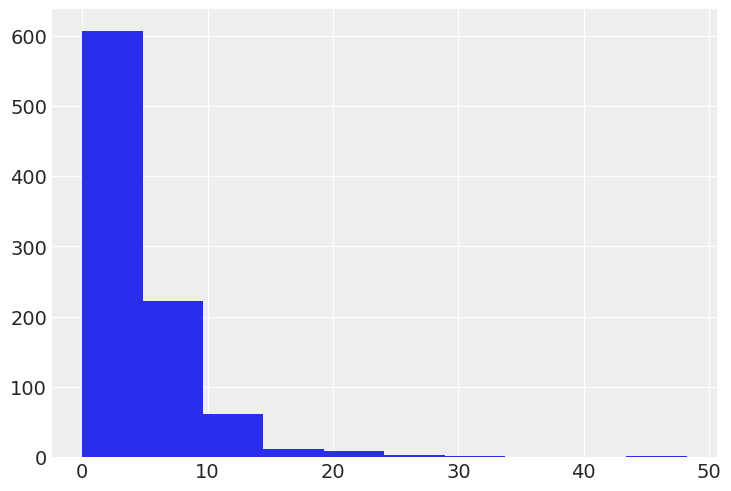

In [60]:
plt.hist(srrs_mn.activity) # radon levels--not gaussian

(array([  3.,   3.,  17.,  46., 174., 261., 251., 134.,  25.,   5.]),
 array([-2.30258509, -1.68458343, -1.06658176, -0.4485801 ,  0.16942157,
         0.78742323,  1.4054249 ,  2.02342656,  2.64142823,  3.2594299 ,
         3.87743156]),
 <BarContainer object of 10 artists>)

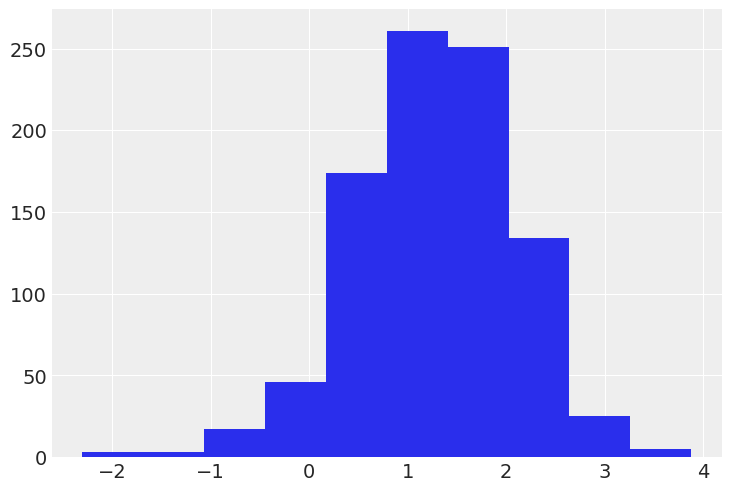

In [61]:
plt.hist(srrs_mn.log_radon) # log radon levels--can be modeled as gaussian

(array([121., 167.,  10., 210.,  94.,  85., 111.,  61.,  29.,  31.]),
 array([0.414025 , 0.5421805, 0.670336 , 0.7984915, 0.926647 , 1.0548025,
        1.182958 , 1.3111135, 1.439269 , 1.5674245, 1.69558  ]),
 <BarContainer object of 10 artists>)

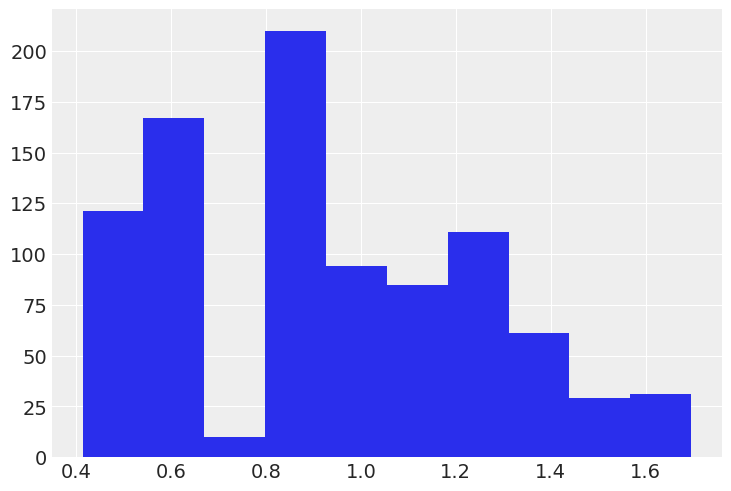

In [62]:
plt.hist(srrs_mn.Uppm)

#### what is this data?

So, each row here represents a measurement of Radon taken in a house in Minnesota, with the location of the measurement (Floor or Basement) and house's county uranium level recorded as the two predictors for radon level. Note that the radon levels can be modeled as gaussian if we take their log, so we do. 

#### model

As the guide notes, there's two extreme ways to think about this model. one is totally pooled, one is totally unpooled (at the county level). If we ignore county our equation would look something like:

$y_i = \alpha + \beta*x_{i} + \epsilon_{i}$

where $x_{i}$ represents our floor index (basement or first floor).

Another option is to provide a separate intercept for each county:

$y_{i,j} = \alpha_j + \beta*x_i + \epsilon_i$ 

where j represents country value. 

Using our hierarchical model, we can implement partial pooling, where the alphas come from a shared distribution whose parameters we also fit. 

Let's start with the unpooled non-hierachical model.

##### note: passing in data

check out more on use of Data Containers here:
https://www.pymc.io/projects/examples/en/latest/fundamentals/data_container.html#data_container




In [47]:
with pm.Model() as pooled_model:
    floor_ind = pm.MutableData("floor_ind", floor_measure, dims="obs_id")

    alpha = pm.Normal("alpha", 0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.Exponential("sigma", 5)

    theta = alpha + beta * floor_ind

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

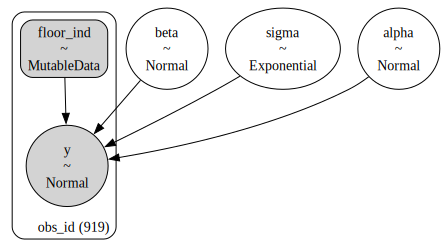

In [65]:
pm.model_to_graphviz(pooled_model)

In [64]:
floor_measure # note that floor_measure, which takes values 0=basement or 1=first floor, is categorical, and needs to be coded as numbers

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [67]:
# prior predictive check: see that the range of possible y cover the observations

with pooled_model:
    prior_checks = pm.sample_prior_predictive(random_seed=42)

Sampling: [alpha, beta, sigma, y]


In [78]:
priors = prior_checks.prior

In [82]:
priors_basement = priors['alpha']
priors_first_floor = priors['alpha'] + priors['beta']

(array([  3.,  10.,  42.,  95., 105.,  96.,  90.,  39.,  15.,   5.]),
 array([-31.41017298, -25.09856506, -18.78695714, -12.47534922,
         -6.1637413 ,   0.14786662,   6.45947454,  12.77108246,
         19.08269038,  25.39429829,  31.70590621]),
 <BarContainer object of 10 artists>)

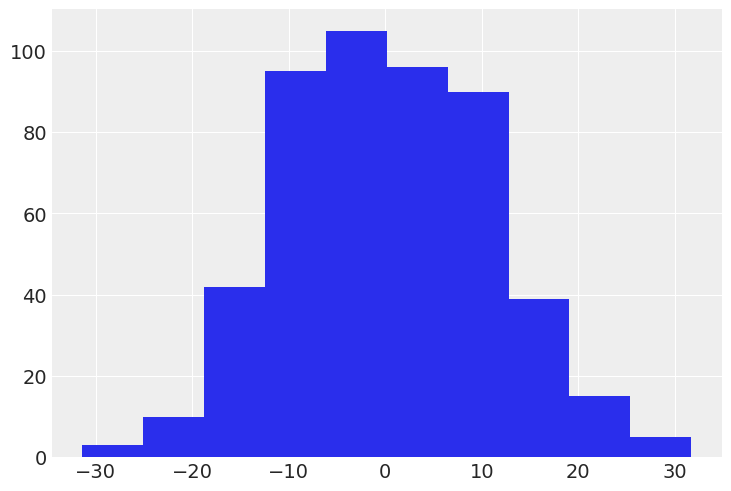

In [90]:
plt.hist(priors_basement[0].values)

(array([ 11.,  29.,  73., 109., 108.,  94.,  37.,  28.,   8.,   3.]),
 array([-36.53515217, -28.19186927, -19.84858637, -11.50530347,
         -3.16202058,   5.18126232,  13.52454522,  21.86782812,
         30.21111101,  38.55439391,  46.89767681]),
 <BarContainer object of 10 artists>)

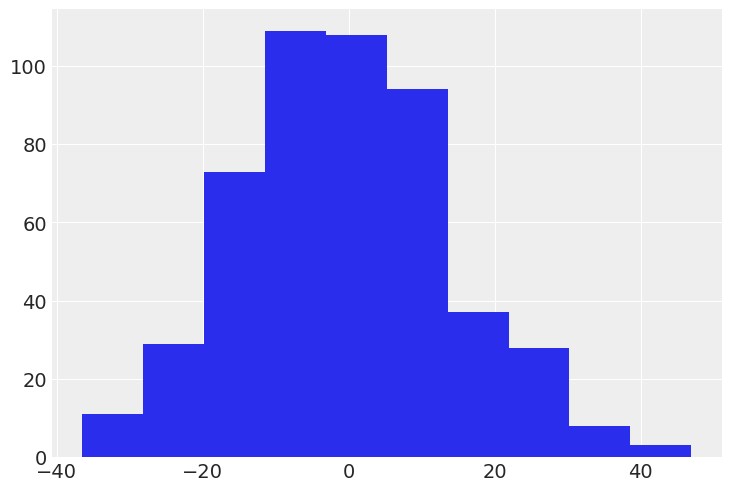

In [89]:
plt.hist(priors_first_floor[0].values)

### prior predictive check conclusion

the range of values certainly covers the observed values. actually, they are spectacularly too wide!


### model results

let's take a look

In [91]:
with pooled_model:
    pooled_trace = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [92]:
az.summary(pooled_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.36,0.03,1.31,1.42,0.0,0.0,4077.17,3337.91,1.0
beta,-0.59,0.07,-0.72,-0.46,0.0,0.0,3800.47,3139.83,1.0
sigma,0.79,0.02,0.76,0.82,0.0,0.0,5716.33,3293.76,1.0


Plotting the real data against the pooled model's expected outcomes (taken by sampling alphas and betas, taking their mean

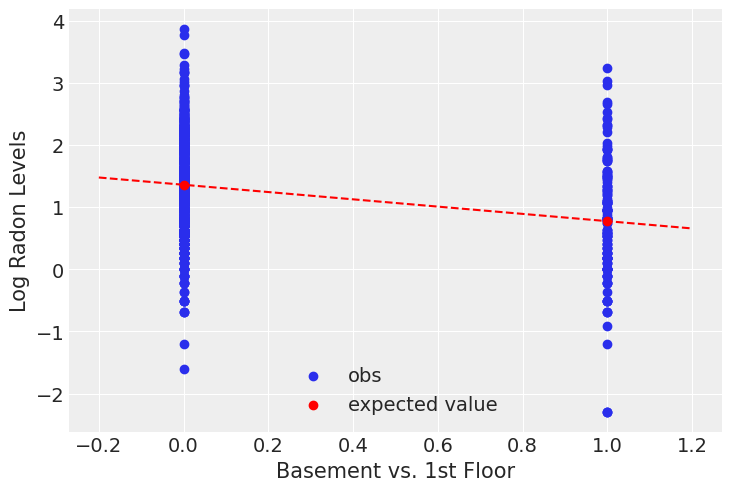

In [114]:
post_mean = pooled_trace.posterior.mean(dim=("chain", "draw"))

plt.scatter(srrs_mn.floor, np.log(srrs_mn.activity + 0.1), label='obs')
plt.scatter([0,1],[post_mean["alpha"],post_mean["beta"]+ post_mean["alpha"]], color='red', label='expected value')
plt.xlabel('Basement vs. 1st Floor')
plt.ylabel('Log Radon Levels')
plt.legend()

xvals = xr.DataArray(np.linspace(-0.2, 1.2))
plt.plot(xvals, post_mean["beta"] * xvals + post_mean["alpha"], "r--");

# ugly plot eh?

### unpooled model

let's look at what happens when we give each county its own intercept. note how we use the coords param to enable this. more examples on coords here: https://www.pymc.io/projects/docs/en/stable/api/model/generated/pymc.model.core.Model.html#pymc.model.core.Model

In [119]:
mn_counties

Index(['AITKIN', 'ANOKA', 'BECKER', 'BELTRAMI', 'BENTON', 'BIG STONE',
       'BLUE EARTH', 'BROWN', 'CARLTON', 'CARVER', 'CASS', 'CHIPPEWA',
       'CHISAGO', 'CLAY', 'CLEARWATER', 'COOK', 'COTTONWOOD', 'CROW WING',
       'DAKOTA', 'DODGE', 'DOUGLAS', 'FARIBAULT', 'FILLMORE', 'FREEBORN',
       'GOODHUE', 'HENNEPIN', 'HOUSTON', 'HUBBARD', 'ISANTI', 'ITASCA',
       'JACKSON', 'KANABEC', 'KANDIYOHI', 'KITTSON', 'KOOCHICHING',
       'LAC QUI PARLE', 'LAKE', 'LAKE OF THE WOODS', 'LE SUEUR', 'LINCOLN',
       'LYON', 'MAHNOMEN', 'MARSHALL', 'MARTIN', 'MCLEOD', 'MEEKER',
       'MILLE LACS', 'MORRISON', 'MOWER', 'MURRAY', 'NICOLLET', 'NOBLES',
       'NORMAN', 'OLMSTED', 'OTTER TAIL', 'PENNINGTON', 'PINE', 'PIPESTONE',
       'POLK', 'POPE', 'RAMSEY', 'REDWOOD', 'RENVILLE', 'RICE', 'ROCK',
       'ROSEAU', 'SCOTT', 'SHERBURNE', 'SIBLEY', 'ST LOUIS', 'STEARNS',
       'STEELE', 'STEVENS', 'SWIFT', 'TODD', 'TRAVERSE', 'WABASHA', 'WADENA',
       'WASECA', 'WASHINGTON', 'WATONWAN', 'WILKIN'

In [120]:
county

array([ 0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,
        9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12,
       12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       14, 14, 14, 14, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       19, 19, 19, 20, 20

let's see what error we get when we don't include coordinates:

In [124]:
with pm.Model() as unpooled_model:
    floor_ind = pm.MutableData("floor_ind", floor_measure, dims="obs_id")

    alpha = pm.Normal("alpha", 0, sigma=10)
    beta = pm.Normal("beta", 0, sigma=10)
    sigma = pm.Exponential("sigma", 1)

    theta = alpha[county] + beta * floor_ind

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

IndexError: too many indices for array

and when we specify county but don't tell it what it is:

In [131]:
with pm.Model() as unpooled_model:
    floor_ind = pm.MutableData("floor_ind", floor_measure, dims="obs_id")

    alpha = pm.Normal("alpha", 0, sigma=10, dims="county")
    beta = pm.Normal("beta", 0, sigma=10)
    sigma = pm.Exponential("sigma", 1)

    theta = alpha[county] + beta * floor_ind

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

KeyError: "Dimensions {'county'} are unknown to the model and cannot be used to specify a `shape`."

but when we do pass in coords, then we get the right shape for alpha:

In [132]:
coords = {"county": mn_counties}

with pm.Model(coords=coords) as unpooled_model:
    floor_ind = pm.MutableData("floor_ind", floor_measure, dims="obs_id")

    alpha = pm.Normal("alpha", 0, sigma=10, dims="county")
    beta = pm.Normal("beta", 0, sigma=10)
    sigma = pm.Exponential("sigma", 1)

    theta = alpha[county] + beta * floor_ind

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

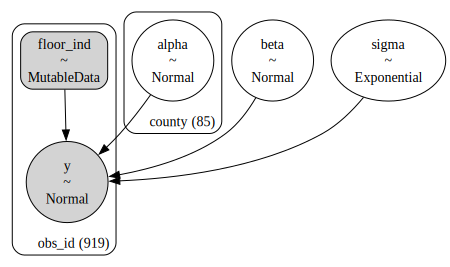

In [133]:
pm.model_to_graphviz(unpooled_model)

In [136]:
with unpooled_model:
    unpooled_trace = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


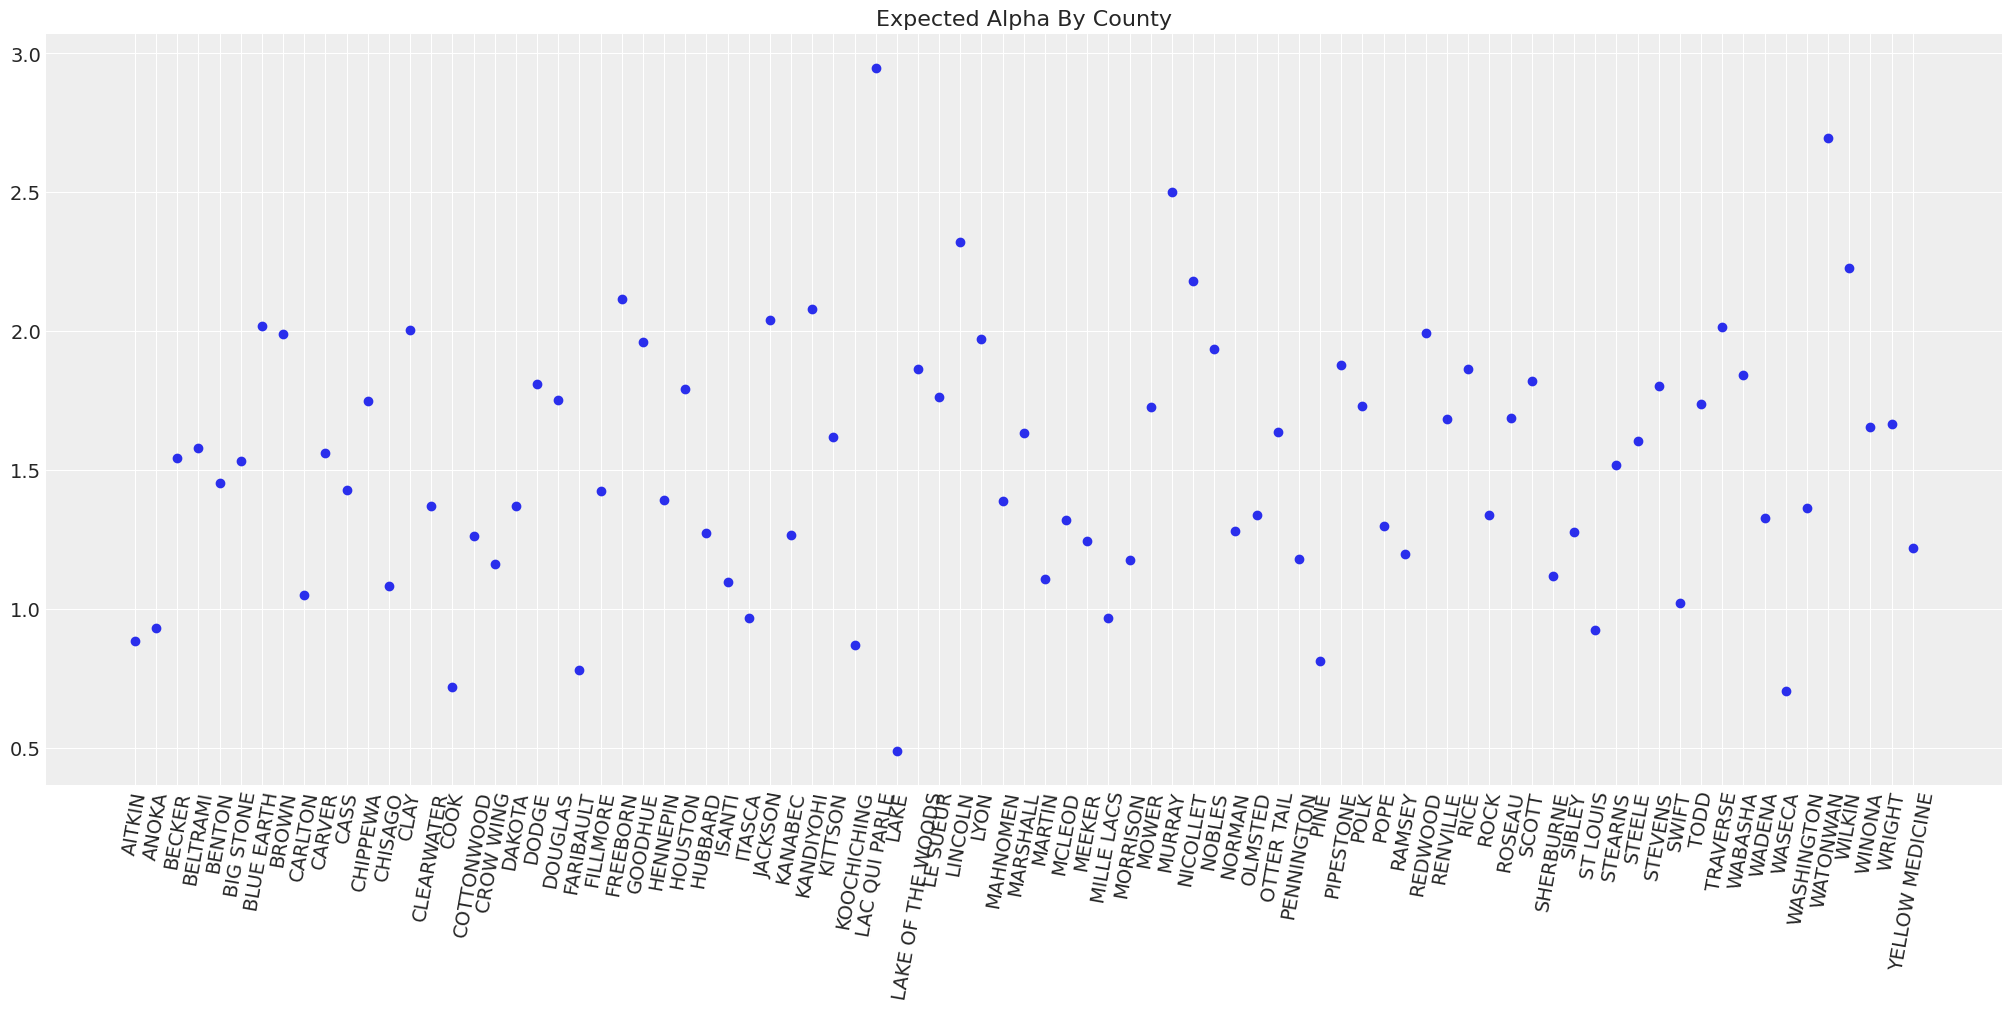

In [160]:
plt.figure(figsize=(20,10))
plt.title('Expected Alpha By County')
plt.xticks(rotation=80)
len(unpooled_trace.posterior.alpha.mean(dim=("chain", "draw")).values)
plt.scatter(mn_counties, unpooled_trace.posterior.alpha.mean(dim=("chain", "draw")).values)

however we can do it even fancier, with intervals...let's use the code snippet provided (not hard to manually reconstruct this by taking quantiles rather than the average of posterior draws across the 'chain' and 'draw' dimensions)

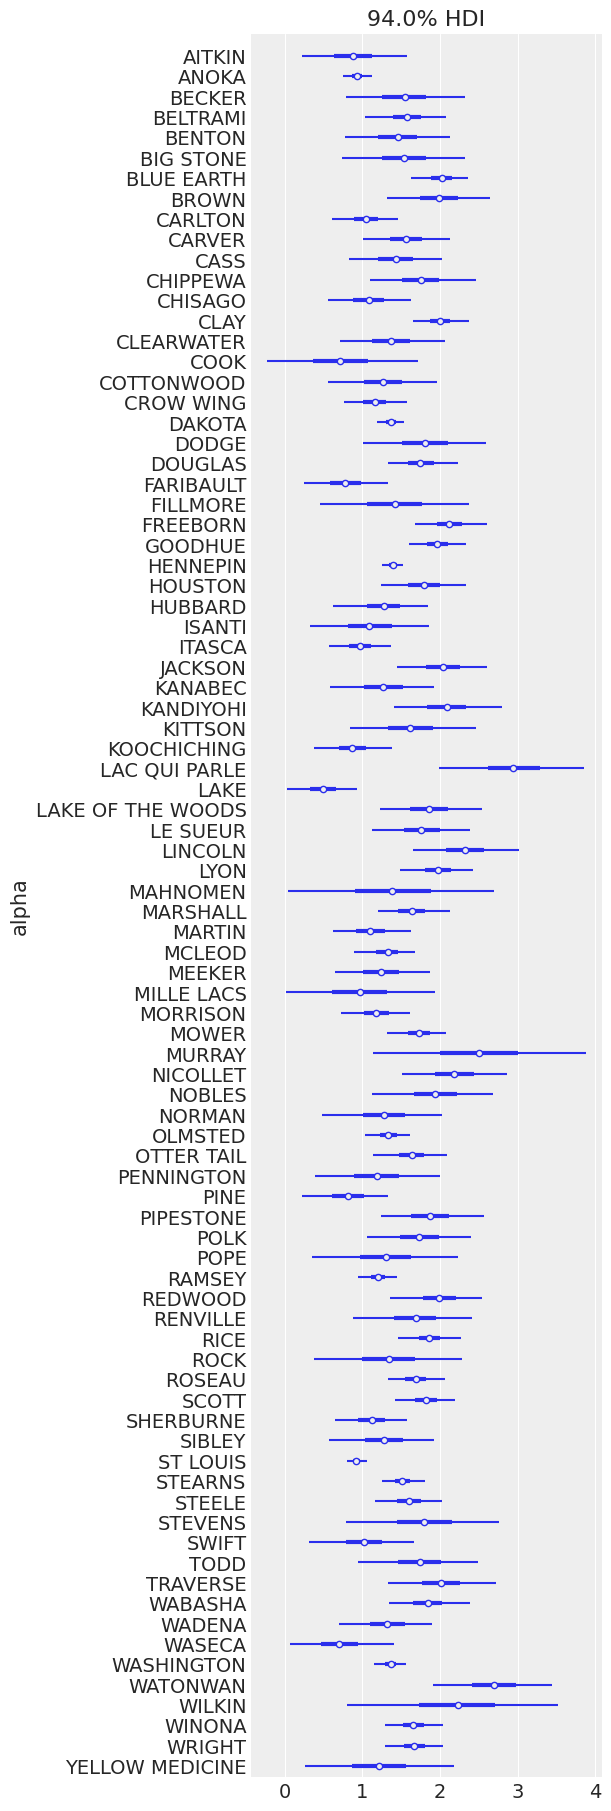

In [162]:
ax = az.plot_forest(
    unpooled_trace,
    var_names=["alpha"],
    r_hat=False,
    combined=True,
    figsize=(6, 18),
    labeller=az.labels.NoVarLabeller(),
)
ax[0].set_ylabel("alpha");

identifying counties with high radon! again, nothing semantically difficult about this.
but there are some really neat functions used here, like az.hdi() (more on that here: https://python.arviz.org/en/stable/api/generated/arviz.hdi.html)

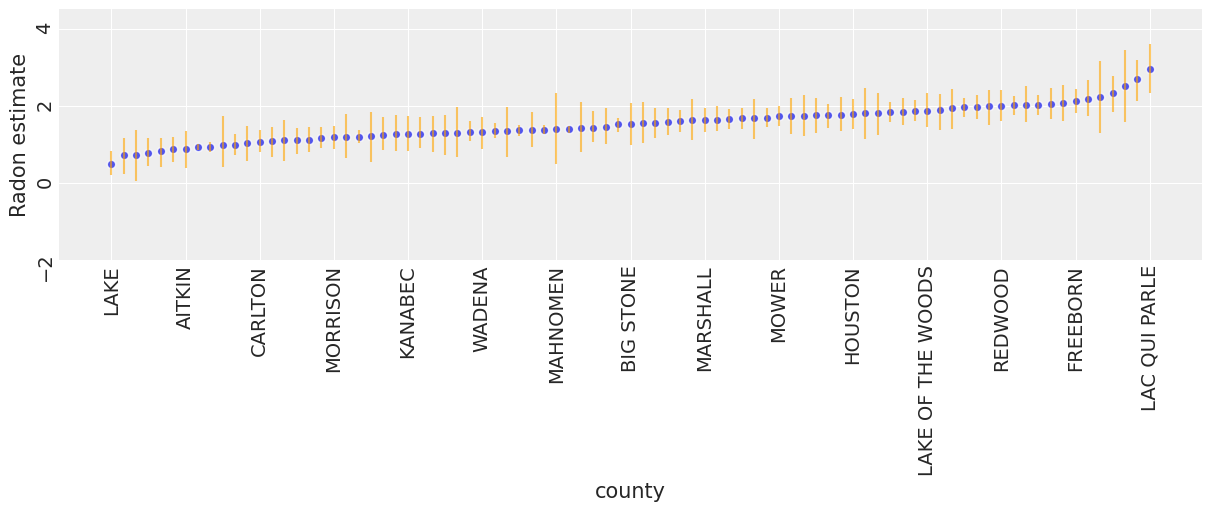

In [173]:
unpooled_means = unpooled_trace.posterior.mean(dim=("chain", "draw"))
unpooled_hdi = az.hdi(unpooled_trace, hdi_prob=0.8) # play with setting the interval size here it's nice

unpooled_means_iter = unpooled_means.sortby("alpha")
unpooled_hdi_iter = unpooled_hdi.sortby(unpooled_means_iter.alpha)

_, ax = plt.subplots(figsize=(12, 5))
xticks = np.arange(0, 86, 6)
unpooled_means_iter.plot.scatter(x="county", y="alpha", ax=ax, alpha=0.8)
ax.vlines(
    np.arange(mn_counties.size),
    unpooled_hdi_iter.alpha.sel(hdi="lower"),
    unpooled_hdi_iter.alpha.sel(hdi="higher"),
    color="orange",
    alpha=0.6,
)
ax.set(ylabel="Radon estimate", ylim=(-2, 4.5))
ax.set_xticks(xticks)
ax.set_xticklabels(unpooled_means_iter.county.values[xticks])
ax.tick_params(rotation=90);

In [168]:
unpooled_hdi.alpha # very convenient that an hdi function exists like this

<xarray.DataArray 'alpha' (county: 85, hdi: 2)>
array([[ 0.21914504,  1.57523193],
       [ 0.75081237,  1.12281665],
       [ 0.7838441 ,  2.32477401],
       [ 1.03387993,  2.08146945],
       [ 0.77066406,  2.12184232],
       [ 0.73848254,  2.31850866],
       [ 1.62387442,  2.35823604],
       [ 1.32093651,  2.64806284],
       [ 0.60447202,  1.46394559],
       [ 1.00819511,  2.13021477],
       [ 0.82869809,  2.02609295],
       [ 1.09872382,  2.45701434],
       [ 0.55159014,  1.6260047 ],
       [ 1.65368743,  2.37044091],
       [ 0.70671173,  2.05748504],
       [-0.2250353 ,  1.7139532 ],
       [ 0.56239121,  1.96532046],
       [ 0.76649854,  1.574413  ],
       [ 1.18886486,  1.53941949],
       [ 1.00942878,  2.58663055],
...
       [ 1.33299612,  2.06053898],
       [ 1.4206951 ,  2.18944948],
       [ 0.64148016,  1.57473776],
       [ 0.56566783,  1.92113914],
       [ 0.80216344,  1.05332335],
       [ 1.25518888,  1.80951712],
       [ 1.16327675,  2.03006045],
       [ 0.79358355,  2.76133877],
       [ 0.30635866,  1.66129562],
       [ 0.94708031,  2.4872377 ],
       [ 1.32378338,  2.71797663],
       [ 1.34757033,  2.38066694],
       [ 0.70014257,  1.89926911],
       [ 0.06067727,  1.41009755],
       [ 1.14909417,  1.55826939],
       [ 1.90955103,  3.44063566],
       [ 0.79851767,  3.51846731],
       [ 1.28930238,  2.03355071],
       [ 1.28630755,  2.034108  ],
       [ 0.25672042,  2.17590725]])
Coordinates:
  * county   (county) <U17 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'
  * hdi      (hdi) <U6 'lower' 'higher'

experimenting with the syntax: in the next section they change it up a bit by dropping 'county' into a mutable data object, I want to see if breaks the code given above

In [174]:
coords = {"county": mn_counties}

with pm.Model(coords=coords) as unpooled_model:
    floor_ind = pm.MutableData("floor_ind", floor_measure, dims="obs_id")
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    alpha = pm.Normal("alpha", 0, sigma=10, dims="county")
    beta = pm.Normal("beta", 0, sigma=10)
    sigma = pm.Exponential("sigma", 1)

    theta = alpha[county_idx] + beta * floor_ind

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

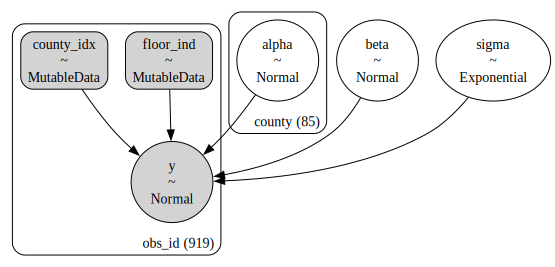

In [175]:
pm.model_to_graphviz(unpooled_model)

works fine!

### Pooled vs. Unpooled

The tutorial goes on to make the point with graphs (which we'll skip) that here, pooled is not useful if we are looking to compare across counties, but unpooled will result in counties with low sample sizes having unrealistically high or low estimates / overfitting to small data (including creating paradoxical results in this dataset where counties with very small n sometimes estimate that radon levels are higher on the first floor than the basement). To strike a balance we want to allow for partial pooling for intercepts, by drawing them from a distributions whose parameters we fit (letting the data guide the degree of correlation we induce).

Note that this is equivalent to introducing a weighted sum between the overall and county level alphas, where the weights are allowed to be inferred from the data themselves rather than predetermined. 




In [176]:
coords = {"county": mn_counties}

with pm.Model(coords=coords) as varying_intercept:
    floor_ind = pm.MutableData("floor_ind", floor_measure, dims="obs_id")
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    # priors for alpha

    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10.0)
    sigma_a = pm.Exponential("sigma_a", 1)

    alpha = pm.Normal("alpha", mu_a, sigma=sigma_a, dims="county")
    beta = pm.Normal("beta", 0, sigma=10)
    sigma = pm.Exponential("sigma", 1)

    theta = alpha[county_idx] + beta * floor_ind

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

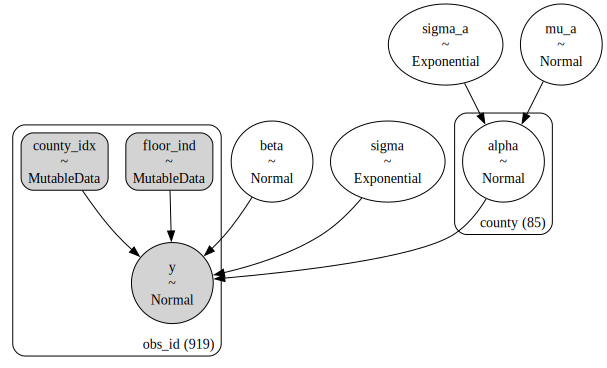

In [177]:
pm.model_to_graphviz(varying_intercept)

In [179]:
with varying_intercept:
    varying_intercept_trace = pm.sample(tune=2000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, alpha, beta, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3 seconds.


### Effect of Partial Pooling in the Varying Intercepts Model

I lifted this code from their section on partial pooling (the same as the model we just ran but with only partially pooled alphas and no other predictors). Same idea applies here but it's more comparable since in the unpooled case we also used predictors. And we can clearly see how the pooling improves our low N estimates (both their unreasonable point estimates and the wide intervals they have to balance them). Shrinkage!

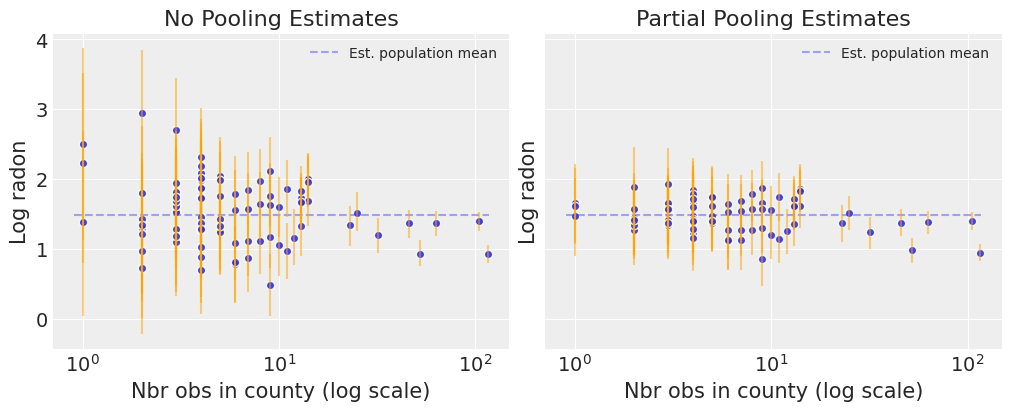

In [181]:
N_county = srrs_mn.groupby("county")["idnum"].count().values

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for ax, trace, level in zip(
    axes,
    (unpooled_trace, varying_intercept_trace),
    ("no pooling", "partial pooling"),
):
    # add variable with x values to xarray dataset
    trace.posterior = trace.posterior.assign_coords({"N_county": ("county", N_county)})
    # plot means
    trace.posterior.mean(dim=("chain", "draw")).plot.scatter(
        x="N_county", y="alpha", ax=ax, alpha=0.9
    )
    ax.hlines(
        varying_intercept_trace.posterior.alpha.mean(),
        0.9,
        max(N_county) + 1,
        alpha=0.4,
        ls="--",
        label="Est. population mean",
    )

    # plot hdi
    hdi = az.hdi(trace).alpha
    ax.vlines(N_county, hdi.sel(hdi="lower"), hdi.sel(hdi="higher"), color="orange", alpha=0.5)

    ax.set(
        title=f"{level.title()} Estimates",
        xlabel="Nbr obs in county (log scale)",
        xscale="log",
        ylabel="Log radon",
    )
    ax.legend(fontsize=10)

Text(0, 0.5, 'alpha')

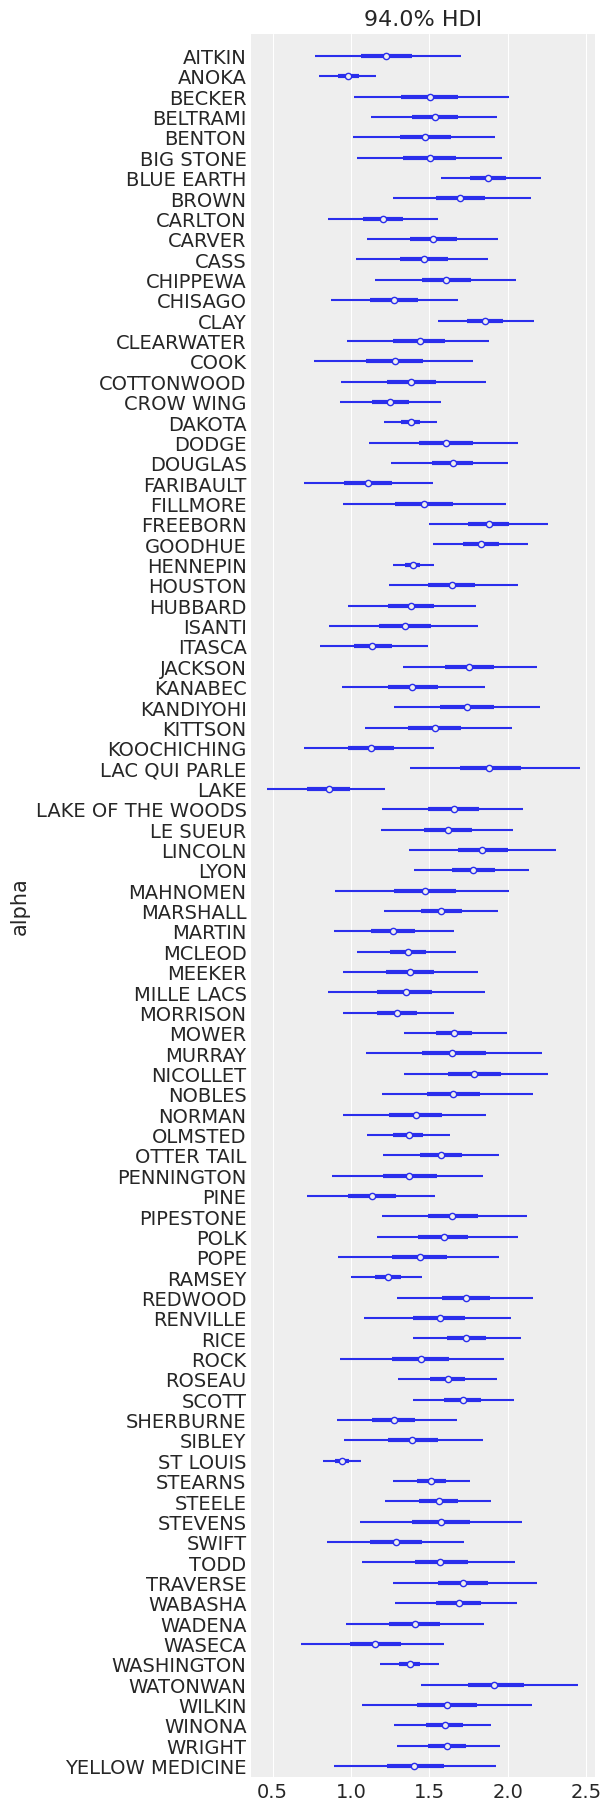

In [182]:
ax = pm.plot_forest(
    varying_intercept_trace,
    var_names=["alpha"],
    figsize=(6, 18),
    combined=True,
    r_hat=False,
    labeller=az.labels.NoVarLabeller(),
)
ax[0].set_ylabel("alpha")

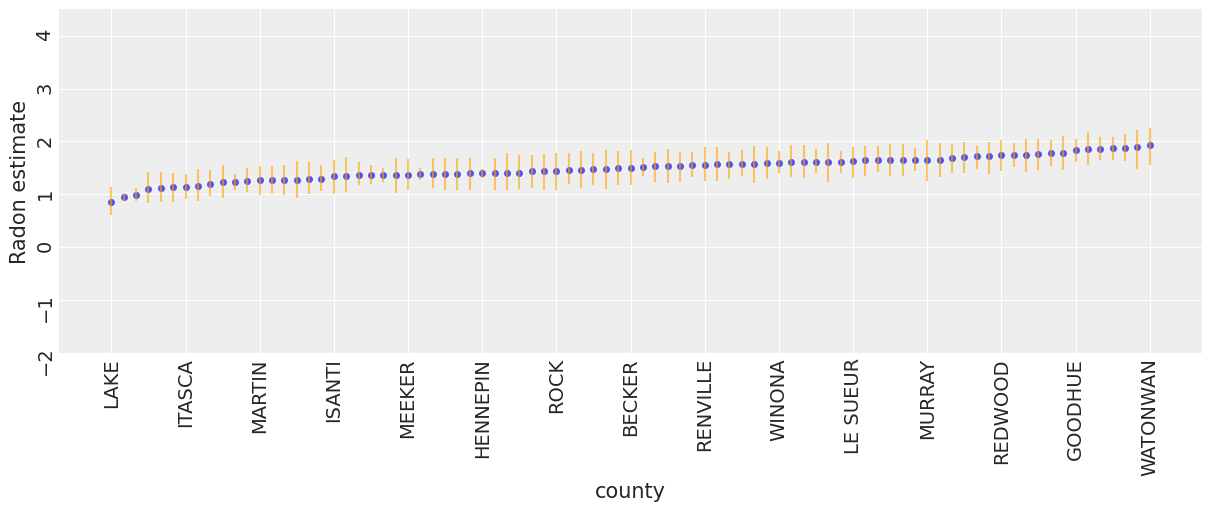

In [183]:
p_pooled_means = varying_intercept_trace.posterior.mean(dim=("chain", "draw"))
p_pooled_hdi = az.hdi(varying_intercept_trace, hdi_prob=0.8) # play with setting the interval size here it's nice

p_pooled_means_iter = p_pooled_means.sortby("alpha")
p_pooled_hdi_iter = p_pooled_hdi.sortby(p_pooled_means_iter.alpha)

_, ax = plt.subplots(figsize=(12, 5))
xticks = np.arange(0, 86, 6)
p_pooled_means_iter.plot.scatter(x="county", y="alpha", ax=ax, alpha=0.8)
ax.vlines(
    np.arange(mn_counties.size),
    p_pooled_hdi_iter.alpha.sel(hdi="lower"),
    p_pooled_hdi_iter.alpha.sel(hdi="higher"),
    color="orange",
    alpha=0.6,
)
ax.set(ylabel="Radon estimate", ylim=(-2, 4.5))
ax.set_xticks(xticks)
ax.set_xticklabels(p_pooled_means_iter.county.values[xticks])
ax.tick_params(rotation=90);

Same plots as last time, different results :) 

#### looking at fitted parameters for alpha


array([<Axes: title={'center': 'mu_a'}>,
       <Axes: title={'center': 'sigma_a'}>], dtype=object)

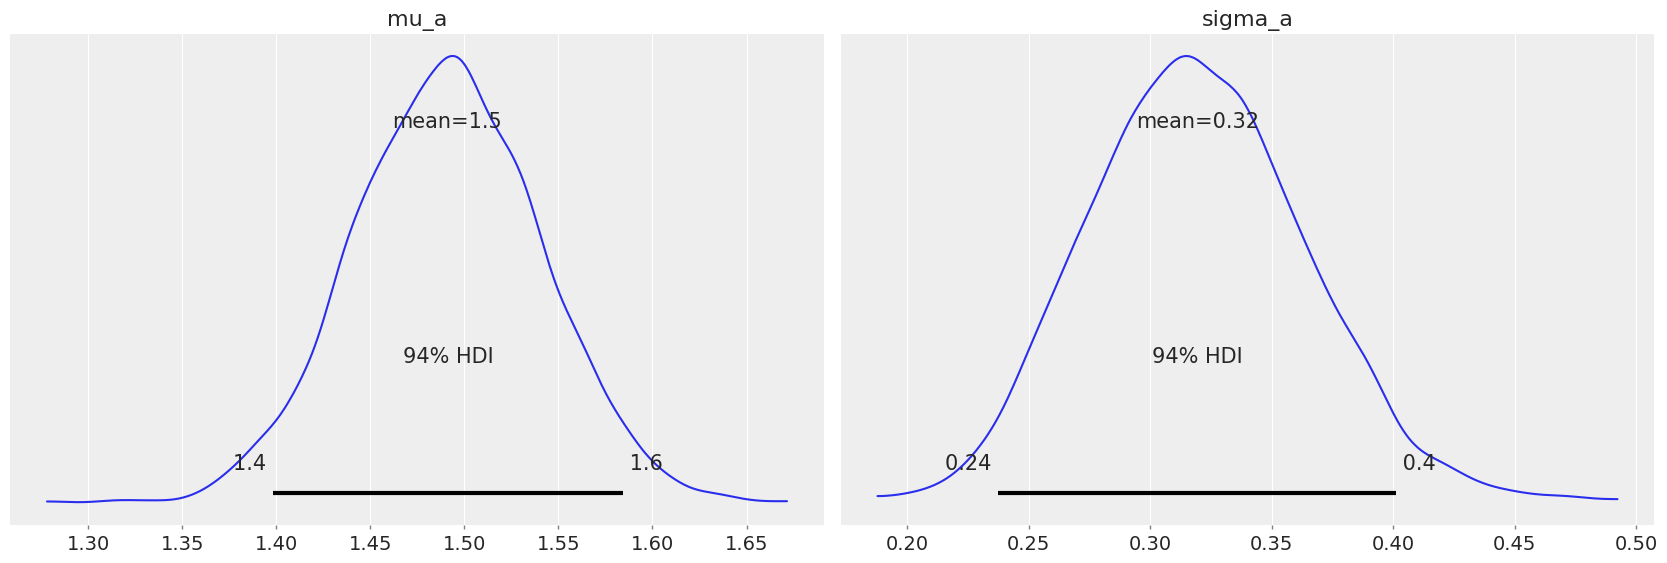

In [189]:
pm.plot_posterior(varying_intercept_trace, var_names=["mu_a", "sigma_a"])

These give us an idea of what the population level variability is between counties (plus we could draw county level distributions for alpha for each county, which is basically what those plots above are)


### Assessing Beta

<Axes: title={'center': 'beta'}>

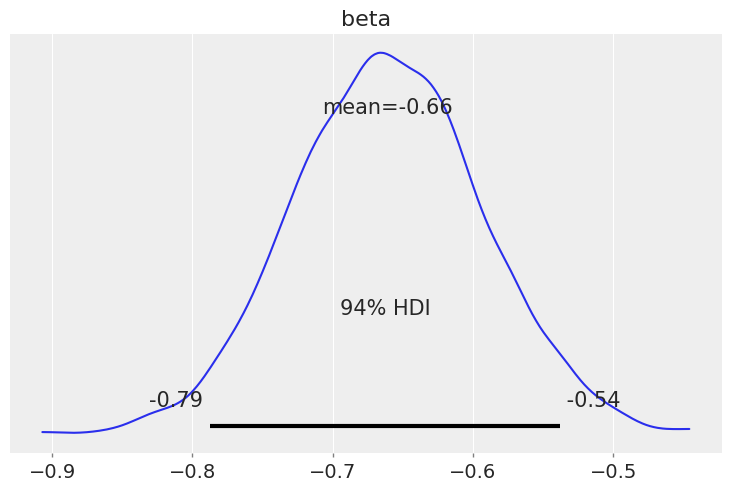

In [190]:
pm.plot_posterior(varying_intercept_trace, var_names=["beta"])

In [191]:
az.summary(varying_intercept_trace, var_names=["beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,-0.661,0.067,-0.788,-0.538,0.001,0.001,3071.0,2869.0,1.0


Based on the plot, houses without basements have exp(-0.66) times as much radon as those without--which is approximately half. 


### Going Deeper: Varying Slopes

We can extend the model a little further in a pretty predictable way--we give beta the same treatment we gave alpha. The tutorial goes even deeper but we'll stop here :) 

In [195]:
coords = {"county": mn_counties}

with pm.Model(coords=coords) as varying_slopes_intercepts:
    floor_ind = pm.MutableData("floor_ind", floor_measure, dims="obs_id")
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    # priors for alpha

    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10.0)
    sigma_a = pm.Exponential("sigma_a", 1)

    # priors for beta

    mu_b = pm.Normal("mu_b", mu=0.0, sigma=10.0)
    sigma_b = pm.Exponential("sigma_b", 1)

    
    alpha = pm.Normal("alpha", mu_a, sigma=sigma_a, dims="county")
    beta = pm.Normal("beta", mu_b, sigma=sigma_b, dims="county") # beta is now also specified dims="county"
    sigma = pm.Exponential("sigma", 1)

    theta = alpha[county_idx] + beta[county_idx] * floor_ind # beta is now also a function of county_idx

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

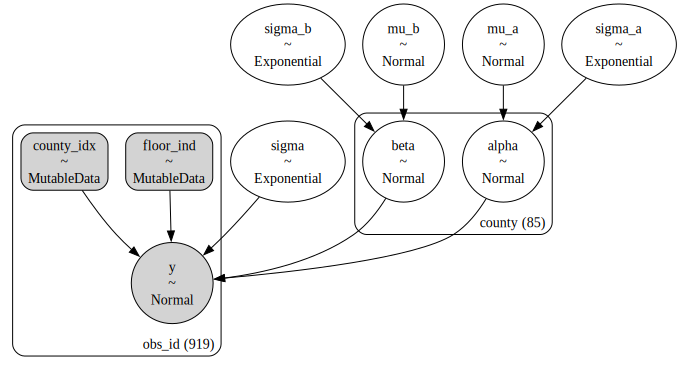

In [197]:
pm.model_to_graphviz(varying_slopes_intercepts)